In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats

## Load Data

In [11]:
file_path = 'data/new_combined_data.csv'
data = pd.read_csv(file_path, header=None)

file_path = 'data/col_with_hands.txt'
columns = pd.read_csv(file_path, header=None)
columns = columns.values
columns = [item for sublist in columns for item in sublist]
data.columns = columns

In [12]:
data['label'].value_counts()

four     5561
seven    5264
six      5237
five     5073
ten      4815
eight    4799
nine     4630
zero     4595
three    4543
one      4199
two      4185
Name: label, dtype: int64

## Balance Data

In [13]:
labels = data['label'].value_counts().index
labels

Index(['four', 'seven', 'six', 'five', 'ten', 'eight', 'nine', 'zero', 'three',
       'one', 'two'],
      dtype='object')

In [14]:
four = data[data['label'] == 'four'].head(4185).copy()
seven = data[data['label'] == 'seven'].head(4185).copy()
six = data[data['label'] == 'six'].head(4185).copy()
five = data[data['label'] == 'five'].head(4185).copy()
ten = data[data['label'] == 'ten'].head(4185).copy()
eight = data[data['label'] == 'eight'].head(4185).copy()
nine = data[data['label'] == 'nine'].head(4185).copy()
zero = data[data['label'] == 'zero'].head(4185).copy()
three = data[data['label'] == 'three'].head(4185).copy()
one = data[data['label'] == 'one'].head(4185).copy()
two = data[data['label'] == 'two'].copy()

balanced_data = pd.DataFrame()
balanced_data = pd.concat([one, ten, seven, six, five, three, zero, four, nine, two, eight])

In [15]:
balanced_data['label'].value_counts()

one      4185
ten      4185
seven    4185
six      4185
five     4185
three    4185
zero     4185
four     4185
nine     4185
two      4185
eight    4185
Name: label, dtype: int64

In [16]:
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['label'])
balanced_data.head()

,hands,fingers,lh_palm_pos_x,lh_palm_pos_y,lh_palm_pos_z,rh_palm_pos_x,rh_palm_pos_y,rh_palm_pos_z,lh_normal_x,lh_normal_y,...,rh_thumb_tip_x,rh_thumb_tip_y,rh_thumb_tip_z,rh_thumb_velocity_x,rh_thumb_velocity_y,rh_thumb_velocity_z,rh_wrist_pos_x,rh_wrist_pos_y,rh_wrist_pos_z,label
4595,1,5,-2.267399,164.093109,86.220093,-2.267399,164.093109,86.220093,-0.243588,0.595211,...,11.157804,212.896317,100.391548,746.382141,2634.570068,2928.313965,-1.929443,113.573937,125.104820,4
4596,1,5,-5.316841,166.202713,79.796143,-5.316841,166.202713,79.796143,-0.099900,0.614017,...,19.361755,214.822296,98.624107,802.853210,13.330700,-78.761024,-3.670151,117.072601,119.892876,4
4597,1,5,-7.809026,170.362442,72.614532,-7.809026,170.362442,72.614532,-0.042060,0.625803,...,22.190699,218.727921,88.537971,-43.821011,73.738022,-373.284332,-5.540063,122.022614,113.463715,4
4598,1,5,-7.843538,172.330566,70.575455,-7.843538,172.330566,70.575455,-0.029886,0.602988,...,23.494055,219.644684,87.215561,-6.882928,62.349968,-126.796227,-6.491505,123.114929,110.209236,4
4599,1,5,-7.804166,174.209656,68.718132,-7.804166,174.209656,68.718132,-0.018148,0.596123,...,24.457937,220.868011,85.326462,-16.562511,66.917625,-93.589287,-7.117955,124.774231,107.997620,4


In [17]:
label.classes_

array(['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'ten',
       'three', 'two', 'zero'], dtype=object)

## Sample Data

In [18]:
Fs = 10
frame_size = Fs * 2    # 20 samples
hop_size = Fs * 1         # increment of 10 samples

def get_frames(df, frame_size, hop_size):
    N_FEATURES = 140    
    
    frames = []
    labels = []  
    for i in range(0, len(df) - frame_size, hop_size):
        hands = df['hands'].values[i: i + frame_size]
        fingers = df['fingers'].values[i: i + frame_size]
        lh_palm_pos_x = df['lh_palm_pos_x'].values[i: i + frame_size]
        lh_palm_pos_y = df['lh_palm_pos_y'].values[i: i + frame_size]
        lh_palm_pos_z = df['lh_palm_pos_z'].values[i: i + frame_size]      
        rh_palm_pos_x = df['rh_palm_pos_x'].values[i: i + frame_size]
        rh_palm_pos_y = df['rh_palm_pos_y'].values[i: i + frame_size]
        rh_palm_pos_z = df['rh_palm_pos_z'].values[i: i + frame_size]
        lh_normal_x = df['lh_normal_x'].values[i: i + frame_size]
        lh_normal_y = df['lh_normal_y'].values[i: i + frame_size]
        lh_normal_z = df['lh_normal_z'].values[i: i + frame_size]
        rh_normal_x = df['rh_normal_x'].values[i: i + frame_size]
        rh_normal_y = df['rh_normal_y'].values[i: i + frame_size]
        rh_normal_z = df['rh_normal_z'].values[i: i + frame_size]
        lh_direction_x = df['lh_direction_x'].values[i: i + frame_size]
        lh_direction_y = df['lh_direction_y'].values[i: i + frame_size]
        lh_direction_z = df['lh_direction_z'].values[i: i + frame_size]
        rh_direction_x = df['rh_direction_x'].values[i: i + frame_size]
        rh_direction_y = df['rh_direction_y'].values[i: i + frame_size]
        rh_direction_z = df['rh_direction_z'].values[i: i + frame_size]
        lh_index_direction_x = df['lh_index_direction_x'].values[i: i + frame_size]
        lh_index_direction_y = df['lh_index_direction_y'].values[i: i + frame_size]
        lh_index_direction_z = df['lh_index_direction_z'].values[i: i + frame_size]
        lh_index_extended = df['lh_index_extended'].values[i: i + frame_size]
        lh_index_tip_x = df['lh_index_tip_x'].values[i: i + frame_size]
        lh_index_tip_y = df['lh_index_tip_y'].values[i: i + frame_size]
        lh_index_tip_z = df['lh_index_tip_z'].values[i: i + frame_size]
        lh_index_velocity_x = df['lh_index_velocity_x'].values[i: i + frame_size]
        lh_index_velocity_y = df['lh_index_velocity_y'].values[i: i + frame_size]
        lh_index_velocity_z = df['lh_index_velocity_z'].values[i: i + frame_size]
        lh_middle_direction_x = df['lh_middle_direction_x'].values[i: i + frame_size]
        lh_middle_direction_y = df['lh_middle_direction_y'].values[i: i + frame_size]
        lh_middle_direction_z = df['lh_middle_direction_z'].values[i: i + frame_size]
        lh_middle_extended = df['lh_middle_extended'].values[i: i + frame_size]
        lh_middle_tip_x = df['lh_middle_tip_x'].values[i: i + frame_size]
        lh_middle_tip_y = df['lh_middle_tip_y'].values[i: i + frame_size]
        lh_middle_tip_z = df['lh_middle_tip_z'].values[i: i + frame_size]
        lh_middle_velocity_x = df['lh_middle_velocity_x'].values[i: i + frame_size]
        lh_middle_velocity_y = df['lh_middle_velocity_y'].values[i: i + frame_size]
        lh_middle_velocity_z = df['lh_middle_velocity_z'].values[i: i + frame_size]
        lh_palm_vel_x = df['lh_palm_vel_x'].values[i: i + frame_size]       
        lh_palm_vel_y = df['lh_palm_vel_y'].values[i: i + frame_size]
        lh_palm_vel_z = df['lh_palm_vel_z'].values[i: i + frame_size]
        lh_pinky_direction_x = df['lh_pinky_direction_x'].values[i: i + frame_size]
        lh_pinky_direction_y = df['lh_pinky_direction_y'].values[i: i + frame_size]
        lh_pinky_direction_z = df['lh_pinky_direction_z'].values[i: i + frame_size]
        lh_pinky_extended = df['lh_pinky_extended'].values[i: i + frame_size]
        lh_pinky_tip_x = df['lh_pinky_tip_x'].values[i: i + frame_size]
        lh_pinky_tip_y = df['lh_pinky_tip_y'].values[i: i + frame_size]
        lh_pinky_tip_z = df['lh_pinky_tip_z'].values[i: i + frame_size]
        lh_pinky_velocity_x = df['lh_pinky_velocity_x'].values[i: i + frame_size]
        lh_pinky_velocity_y = df['lh_pinky_velocity_y'].values[i: i + frame_size]
        lh_pinky_velocity_z = df['lh_pinky_velocity_z'].values[i: i + frame_size]
        lh_ring_direction_x = df['lh_ring_direction_x'].values[i: i + frame_size]
        lh_ring_direction_y = df['lh_ring_direction_y'].values[i: i + frame_size]
        lh_ring_direction_z = df['lh_ring_direction_z'].values[i: i + frame_size]
        lh_ring_extended = df['lh_ring_extended'].values[i: i + frame_size]
        lh_ring_tip_x = df['lh_ring_tip_x'].values[i: i + frame_size]
        lh_ring_tip_y = df['lh_ring_tip_y'].values[i: i + frame_size]
        lh_ring_tip_z = df['lh_ring_tip_z'].values[i: i + frame_size]
        lh_ring_velocity_x = df['lh_ring_velocity_x'].values[i: i + frame_size]
        lh_ring_velocity_y = df['lh_ring_velocity_y'].values[i: i + frame_size]
        lh_ring_velocity_z = df['lh_ring_velocity_z'].values[i: i + frame_size]
        lh_sphere_center_x = df['lh_sphere_center_x'].values[i: i + frame_size]
        lh_sphere_center_y = df['lh_sphere_center_y'].values[i: i + frame_size]
        lh_sphere_center_z = df['lh_sphere_center_z'].values[i: i + frame_size]
        lh_sphere_radius = df['lh_sphere_radius'].values[i: i + frame_size]
        lh_thumb_direction_x = df['lh_thumb_direction_x'].values[i: i + frame_size]
        lh_thumb_direction_y = df['lh_thumb_direction_y'].values[i: i + frame_size]
        lh_thumb_direction_z = df['lh_thumb_direction_z'].values[i: i + frame_size]
        lh_thumb_extended = df['lh_thumb_extended'].values[i: i + frame_size]        
        lh_thumb_tip_x = df['lh_thumb_tip_x'].values[i: i + frame_size]
        lh_thumb_tip_y = df['lh_thumb_tip_y'].values[i: i + frame_size]
        lh_thumb_tip_z = df['lh_thumb_tip_z'].values[i: i + frame_size]
        lh_thumb_velocity_x = df['lh_thumb_velocity_x'].values[i: i + frame_size]
        lh_thumb_velocity_y = df['lh_thumb_velocity_y'].values[i: i + frame_size]
        lh_thumb_velocity_z = df['lh_thumb_velocity_z'].values[i: i + frame_size]
        lh_wrist_pos_x = df['lh_wrist_pos_x'].values[i: i + frame_size]
        lh_wrist_pos_y = df['lh_wrist_pos_y'].values[i: i + frame_size]
        lh_wrist_pos_z = df['lh_wrist_pos_z'].values[i: i + frame_size]
        rh_index_direction_x = df['rh_index_direction_x'].values[i: i + frame_size]
        rh_index_direction_y = df['rh_index_direction_y'].values[i: i + frame_size]
        rh_index_direction_z = df['rh_index_direction_z'].values[i: i + frame_size]
        rh_index_extended = df['rh_index_extended'].values[i: i + frame_size]
        rh_index_tip_x = df['rh_index_tip_x'].values[i: i + frame_size]
        rh_index_tip_y = df['rh_index_tip_y'].values[i: i + frame_size]
        rh_index_tip_z = df['rh_index_tip_z'].values[i: i + frame_size]
        rh_index_velocity_x = df['rh_index_velocity_x'].values[i: i + frame_size]
        rh_index_velocity_y = df['rh_index_velocity_y'].values[i: i + frame_size]
        rh_index_velocity_z = df['rh_index_velocity_z'].values[i: i + frame_size]
        rh_middle_direction_x = df['rh_middle_direction_x'].values[i: i + frame_size]
        rh_middle_direction_y = df['rh_middle_direction_y'].values[i: i + frame_size]
        rh_middle_direction_z = df['rh_middle_direction_z'].values[i: i + frame_size]
        rh_middle_extended = df['rh_middle_extended'].values[i: i + frame_size]
        rh_middle_tip_x = df['rh_middle_tip_x'].values[i: i + frame_size]
        rh_middle_tip_y = df['rh_middle_tip_y'].values[i: i + frame_size]
        rh_middle_tip_z = df['rh_middle_tip_z'].values[i: i + frame_size]
        rh_middle_velocity_x = df['rh_middle_velocity_x'].values[i: i + frame_size]
        rh_middle_velocity_y = df['rh_middle_velocity_y'].values[i: i + frame_size]
        rh_middle_velocity_z = df['rh_middle_velocity_z'].values[i: i + frame_size]
        rh_palm_vel_x = df['rh_palm_vel_x'].values[i: i + frame_size]
        rh_palm_vel_y = df['rh_palm_vel_y'].values[i: i + frame_size]
        rh_palm_vel_z = df['rh_palm_vel_z'].values[i: i + frame_size]
        rh_pinky_direction_x = df['rh_pinky_direction_x'].values[i: i + frame_size]
        rh_pinky_direction_y = df['rh_pinky_direction_y'].values[i: i + frame_size]
        rh_pinky_direction_z = df['rh_pinky_direction_z'].values[i: i + frame_size]
        rh_pinky_extended = df['rh_pinky_extended'].values[i: i + frame_size]
        rh_pinky_tip_x = df['rh_pinky_tip_x'].values[i: i + frame_size]
        rh_pinky_tip_y = df['rh_pinky_tip_y'].values[i: i + frame_size]
        rh_pinky_tip_z = df['rh_pinky_tip_z'].values[i: i + frame_size]        
        rh_pinky_velocity_x = df['rh_pinky_velocity_x'].values[i: i + frame_size]
        rh_pinky_velocity_y = df['rh_pinky_velocity_y'].values[i: i + frame_size]
        rh_pinky_velocity_z = df['rh_pinky_velocity_z'].values[i: i + frame_size]
        rh_ring_direction_x = df['rh_ring_direction_x'].values[i: i + frame_size]
        rh_ring_direction_y = df['rh_ring_direction_y'].values[i: i + frame_size]
        rh_ring_direction_z = df['rh_ring_direction_z'].values[i: i + frame_size]
        rh_ring_extended = df['rh_ring_extended'].values[i: i + frame_size]
        rh_ring_tip_x = df['rh_ring_tip_x'].values[i: i + frame_size]
        rh_ring_tip_y = df['rh_ring_tip_y'].values[i: i + frame_size]
        rh_ring_tip_z = df['rh_ring_tip_z'].values[i: i + frame_size]
        rh_ring_velocity_x = df['rh_ring_velocity_x'].values[i: i + frame_size]
        rh_ring_velocity_y = df['rh_ring_velocity_y'].values[i: i + frame_size]
        rh_ring_velocity_z = df['rh_ring_velocity_z'].values[i: i + frame_size]
        rh_sphere_center_x = df['rh_sphere_center_x'].values[i: i + frame_size]
        rh_sphere_center_y = df['rh_sphere_center_y'].values[i: i + frame_size]
        rh_sphere_center_z = df['rh_sphere_center_z'].values[i: i + frame_size]
        rh_sphere_radius = df['rh_sphere_radius'].values[i: i + frame_size]
        rh_thumb_direction_x = df['rh_thumb_direction_x'].values[i: i + frame_size]
        rh_thumb_direction_y = df['rh_thumb_direction_y'].values[i: i + frame_size]
        rh_thumb_direction_z = df['rh_thumb_direction_z'].values[i: i + frame_size]
        rh_thumb_extended = df['rh_thumb_extended'].values[i: i + frame_size]
        rh_thumb_tip_x = df['rh_thumb_tip_x'].values[i: i + frame_size]
        rh_thumb_tip_y = df['rh_thumb_tip_y'].values[i: i + frame_size]
        rh_thumb_tip_z = df['rh_thumb_tip_z'].values[i: i + frame_size]
        rh_thumb_velocity_x = df['rh_thumb_velocity_x'].values[i: i + frame_size]
        rh_thumb_velocity_y = df['rh_thumb_velocity_y'].values[i: i + frame_size]
        rh_thumb_velocity_z = df['rh_thumb_velocity_z'].values[i: i + frame_size]   
        rh_wrist_pos_x = df['rh_wrist_pos_x'].values[i: i + frame_size]
        rh_wrist_pos_y = df['rh_wrist_pos_y'].values[i: i + frame_size]
        rh_wrist_pos_z = df['rh_wrist_pos_z'].values[i: i + frame_size]
        
        # Retrieve the most common label in this data sample
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([hands,fingers,lh_palm_pos_x,lh_palm_pos_y,lh_palm_pos_z,rh_palm_pos_x,rh_palm_pos_y,rh_palm_pos_z,lh_normal_x,lh_normal_y,lh_normal_z,rh_normal_x,rh_normal_y,rh_normal_z,lh_direction_x,lh_direction_y,lh_direction_z,rh_direction_x,rh_direction_y,rh_direction_z,lh_index_direction_x,lh_index_direction_y,lh_index_direction_z,lh_index_extended,lh_index_tip_x,lh_index_tip_y,lh_index_tip_z,lh_index_velocity_x,lh_index_velocity_y,lh_index_velocity_z,lh_middle_direction_x,lh_middle_direction_y,lh_middle_direction_z,lh_middle_extended,lh_middle_tip_x,lh_middle_tip_y,lh_middle_tip_z,lh_middle_velocity_x,lh_middle_velocity_y,lh_middle_velocity_z,lh_palm_vel_x,lh_palm_vel_y,lh_palm_vel_z,lh_pinky_direction_x,lh_pinky_direction_y,lh_pinky_direction_z,lh_pinky_extended,lh_pinky_tip_x,lh_pinky_tip_y,lh_pinky_tip_z,lh_pinky_velocity_x,lh_pinky_velocity_y,lh_pinky_velocity_z,lh_ring_direction_x,lh_ring_direction_y,lh_ring_direction_z,lh_ring_extended,lh_ring_tip_x,lh_ring_tip_y,lh_ring_tip_z,lh_ring_velocity_x,lh_ring_velocity_y,lh_ring_velocity_z,lh_sphere_center_x,lh_sphere_center_y,lh_sphere_center_z,lh_sphere_radius,lh_thumb_direction_x,lh_thumb_direction_y,lh_thumb_direction_z,lh_thumb_extended,lh_thumb_tip_x,lh_thumb_tip_y,lh_thumb_tip_z,lh_thumb_velocity_x,lh_thumb_velocity_y,lh_thumb_velocity_z,lh_wrist_pos_x,lh_wrist_pos_y,lh_wrist_pos_z,rh_index_direction_x,rh_index_direction_y,rh_index_direction_z,rh_index_extended,rh_index_tip_x,rh_index_tip_y,rh_index_tip_z,rh_index_velocity_x,rh_index_velocity_y,rh_index_velocity_z,rh_middle_direction_x,rh_middle_direction_y,rh_middle_direction_z,rh_middle_extended,rh_middle_tip_x,rh_middle_tip_y,rh_middle_tip_z,rh_middle_velocity_x,rh_middle_velocity_y,rh_middle_velocity_z,rh_palm_vel_x,rh_palm_vel_y,rh_palm_vel_z,rh_pinky_direction_x,rh_pinky_direction_y,rh_pinky_direction_z,rh_pinky_extended,rh_pinky_tip_x,rh_pinky_tip_y,rh_pinky_tip_z,rh_pinky_velocity_x,rh_pinky_velocity_y,rh_pinky_velocity_z,rh_ring_direction_x,rh_ring_direction_y,rh_ring_direction_z,rh_ring_extended,rh_ring_tip_x,rh_ring_tip_y,rh_ring_tip_z,rh_ring_velocity_x,rh_ring_velocity_y,rh_ring_velocity_z,rh_sphere_center_x,rh_sphere_center_y,rh_sphere_center_z,rh_sphere_radius,rh_thumb_direction_x,rh_thumb_direction_y,rh_thumb_direction_z,rh_thumb_extended,rh_thumb_tip_x,rh_thumb_tip_y,rh_thumb_tip_z,rh_thumb_velocity_x,rh_thumb_velocity_y,rh_thumb_velocity_z,rh_wrist_pos_x,rh_wrist_pos_y,rh_wrist_pos_z])
        labels.append(label)
            
     # Convert to np array
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels

In [19]:
X, y = get_frames(balanced_data, frame_size, hop_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Reshape into 3-dimentional
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_train.shape[2], 1)

## Setup CNN Model

In [20]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(11, activation='softmax'))

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
101/101 [==============================] - 7s 49ms/step - loss: 23.2287 - accuracy: 0.3648 - val_loss: 1.5365 - val_accuracy: 0.5069
Epoch 2/10
101/101 [==============================] - 5s 47ms/step - loss: 0.8717 - accuracy: 0.6740 - val_loss: 1.0520 - val_accuracy: 0.8059
Epoch 3/10
101/101 [==============================] - 5s 47ms/step - loss: 0.4627 - accuracy: 0.8687 - val_loss: 0.8158 - val_accuracy: 0.8993
Epoch 4/10
101/101 [==============================] - 5s 47ms/step - loss: 0.3484 - accuracy: 0.9168 - val_loss: 0.7503 - val_accuracy: 0.8950
Epoch 5/10
101/101 [==============================] - 5s 47ms/step - loss: 0.2396 - accuracy: 0.9326 - val_loss: 0.6494 - val_accuracy: 0.9232
Epoch 6/10
101/101 [==============================] - 5s 48ms/step - loss: 0.1889 - accuracy: 0.9407 - val_loss: 0.6994 - val_accuracy: 0.9261
Epoch 7/10
101/101 [==============================] - 5s 47ms/step - loss: 0.1935 - accuracy: 0.9450 - val_loss: 0.5775 - val_accuracy: 0.899

## Accuracy and Loss Visualisation

In [23]:
def plot_learning_curve(history, epochs):
    # training and validation values
    epoch_range = range(1, epochs + 1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    # training and validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

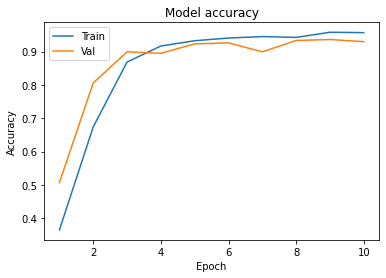

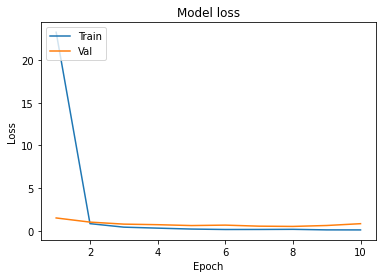

In [24]:
plot_learning_curve(history, 10)

## Confusion Matrix

In [25]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

max_y_pred = []
for item in y_pred:
    max_y_pred.append(np.argmax(item))

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

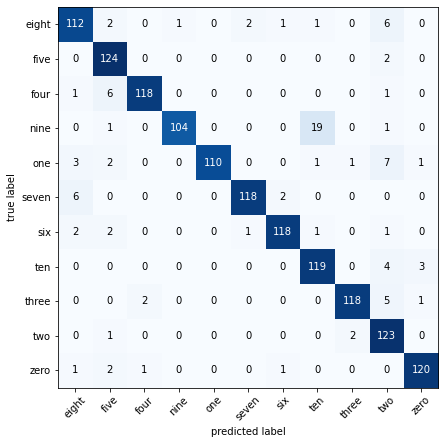

In [26]:
mat = confusion_matrix(y_test, max_y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=False, figsize=(7, 7))

## Save Model

In [27]:
model.save('saved_models/sampling')

INFO:tensorflow:Assets written to: saved_models/sampling\assets
